In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train_multiview_network import TrainMultiInputModel
from multi_view_classification_network import MultiInputModel
from config import get_config
import torch
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
from torchvision import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ptflops as ptf
import os
from copy import deepcopy

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning last features layers...
[INFO]: Number of training images: 2307,2307
[INFO]: Number of validation images: 577,577
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 2e-05
Epochs to train for: 10

33,615,815 total parameters.
33,615,815 training parameters.
[INFO]: Epoch 1 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 1.186, training acc: 68.704
Validation loss: 0.335, validation acc: 94.801
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.261, training acc: 94.322
Validation loss: 0.119, validation acc: 96.707
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.104, training acc: 97.659
Validation loss: 0.085, validation acc: 96.880
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.047, training acc: 99.306
Validation loss: 0.091, validation acc: 96.707
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.027, training acc: 99.480
Validation loss: 0.082, validation acc: 97.227
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.017, training acc: 99.870
Validation loss: 0.089, validation acc: 97.574
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.011, training acc: 99.913
Validation loss: 0.081, validation acc: 97.574
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.006, training acc: 100.000
Validation loss: 0.077, validation acc: 97.574
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.004, training acc: 100.000
Validation loss: 0.079, validation acc: 97.227
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


  0%|          | 0/73 [00:00<?, ?it/s]

Validation


  0%|          | 0/19 [00:00<?, ?it/s]

Training loss: 0.003, training acc: 100.000
Validation loss: 0.082, validation acc: 97.400
--------------------------------------------------


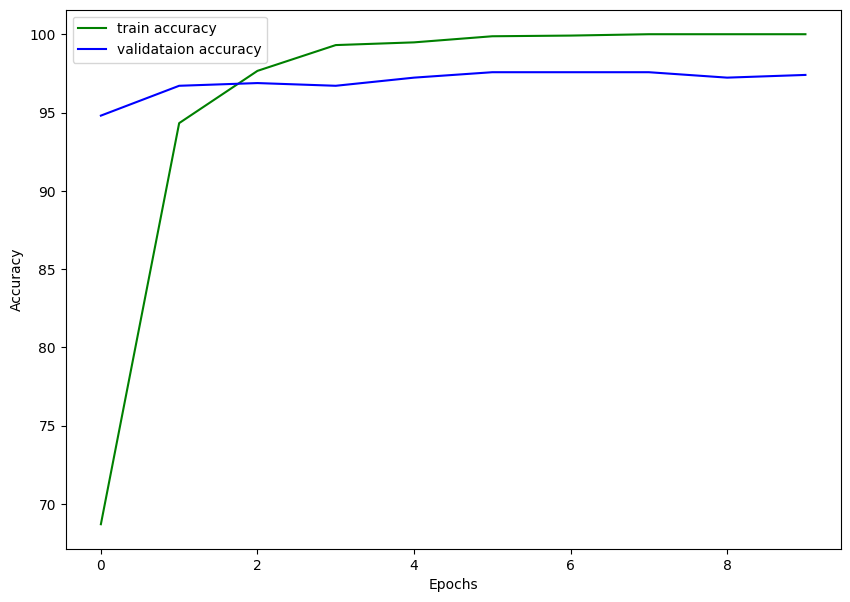

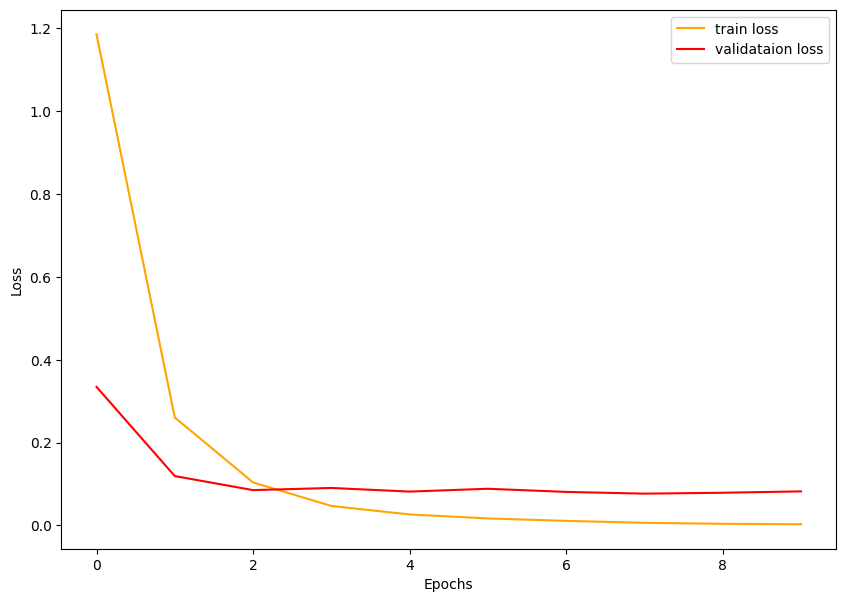

In [5]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def modified_resnet(model):
    model.fc = Identity()
    return model

def modified_densenet(model):
    model.classifier = Identity()
    return model 

DATA_CONFIG={
                'ROOT_DIR': '/home/onyxia/work/data/Images_ROI/Images_ROI_Typ_for_multiview/',
                'VALID_SPLIT': 0.2,
                'TEST_SPLIT': 0.5,
                'IMAGE_SIZE': 224,  # Image size of resize when applying transforms.
                'BATCH_SIZE': 32,
                'NUM_WORKERS': 0
                }

torch.cuda.empty_cache()
models = [{'model':torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1'),
                                      'avgpool':torch.nn.AdaptiveAvgPool2d(1),
                                      'last_layer_size':2048,
                                      'model_name' : 'EfficientNet',
                                       'features' : None
          },
          {'model':torchvision.models.densenet121(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':1024,
                                  'model_name' : 'DenseNet121',
                                   'features' : modified_densenet(torchvision.models.densenet121(weights='IMAGENET1K_V1')),
            },
          {'model':torchvision.models.resnet50(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet50',
                                   'features' : modified_resnet(torchvision.models.resnet50(weights='IMAGENET1K_V1'))
            },
          {'model':torchvision.models.vgg16(weights='IMAGENET1K_V1'),
                                  'avgpool':torch.nn.AdaptiveAvgPool2d((1,1)),
                                  'last_layer_size':512,
                                  'model_name' : 'VGG',
                                   'features' : None
            },
          
          {'model':torchvision.models.resnet152(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet152',
                                   'features' : modified_resnet(torchvision.models.resnet152(weights='IMAGENET1K_V1'))
            }
          
]

model_config = {'learning_rate' : 0.00002,
                "epochs" : 10,
                "pretrained":True,
                "fine_tune":True,
                "model_recto": deepcopy(models[2]),
                "model_verso": deepcopy(models[1]),
                         }
torch.cuda.empty_cache()
trainer = TrainMultiInputModel(model_config,DATA_CONFIG)
trainer.train_and_validate()

In [6]:
y_obs = []
for i, recto in tqdm(enumerate(trainer.testRectoloader), total=len(trainer.testVersoloader)):
        _, labels = recto
        y_obs.append(labels.tolist())
y_obs = [item for sublist in y_obs for item in sublist]
#print(Counter(y_obs))
print(len(y_obs))

100%|██████████| 91/91 [00:32<00:00,  2.77it/s]

2885


In [8]:
def input_constructor(input_res):
            recto = torch.ones(()).new_empty((1, *input_res),
                                                     device=trainer.device) 
            verso = torch.ones(()).new_empty((1, *input_res),
                                                     device=trainer.device)
            return {"two_views": [recto,verso]}

lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)


output_res50_dense121 = {}
temp = {}
model_config = {'learning_rate' : 0.00002,
            "epochs" : 10,
            "pretrained":True,
            "fine_tune":True,
            "model_recto":deepcopy(models[2]),
            "model_verso":deepcopy(models[1]),
         }
torch.cuda.empty_cache()
trainer = TrainMultiInputModel(model_config,DATA_CONFIG)
#model_recto = models[2]
#model_verso =   models[2]           
#model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=True,num_classes=7)
checkpoint = torch.load(f'{trainer.main_path}/outputs/model_recto_{models[2]["model_name"]}_model_verso_{models[1]["model_name"]}_epochs_10_lr_2e-05_batch_size_32_pretrained_True_fine_tune_True.pth', map_location="cuda")
#model.load_state_dict({cle: checkpoint['model_state_dict'][cle] for cle in checkpoint['model_state_dict'].keys() if not cle.startswith("modelRecto.") and not cle.startswith("modelVerso.")})
trainer.model.load_state_dict(checkpoint['model_state_dict'])
trainer.model = trainer.model.to(trainer.device)
#trainer.model = model
preds, max_probs, all_probs = trainer.predict(trainer.testRectoloader,trainer.testVersoloader)
macs,_ = ptf.get_model_complexity_info(trainer.model, (3, 224, 224), as_strings=False,
                                       print_per_layer_stat=False, verbose=False,input_constructor = input_constructor)
output_res50_dense121 = {
"pred" : le.inverse_transform(preds).tolist(),
"max_probs" : max_probs,
"all_probs" : all_probs,
"accuracy" : accuracy_score(y_obs,preds),
"balanced_accuracy" : balanced_accuracy_score(y_obs,preds),
"precision_micro" : precision_score(y_obs,preds,average="micro"),
"recall_micro" : recall_score(y_obs,preds,average="micro"),
"precision_micro" : precision_score(y_obs,preds,average="micro"),
"recall_micro" : recall_score(y_obs,preds,average="micro"),
"roc_auc_micro" : roc_auc_score(y_obs,all_probs,average="micro",multi_class='ovr'),
"f1_score_micro" : f1_score(y_obs,preds,average="micro"),
"precision_weighted" : precision_score(y_obs,preds,average="weighted"),
"recall_weighted" : recall_score(y_obs,preds,average="weighted"),
"precision_weighted" : precision_score(y_obs,preds,average="weighted"),
"recall_weighted" : recall_score(y_obs,preds,average="weighted"),
"roc_auc_weighted" : roc_auc_score(y_obs,all_probs,average="weighted",multi_class='ovo'),
"f1_score_weighted" : f1_score(y_obs,preds,average="weighted"),
"nb_trainable_parameters" : sum(
p.numel() for p in trainer.model.parameters() if p.requires_grad),
"nb_parameters" : sum(
p.numel() for p in trainer.model.parameters()),
"macs" : macs
}

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning last features layers...


  0%|          | 0/91 [00:00<?, ?it/s]

Warning! No positional inputs found for a module, assuming batch size is 1.


In [9]:
output_res50_dense121["accuracy"]

0.97157712305026